# Imports

In [2]:
#cropping imports
import os
import cv2
import torch
from torch.utils.data import Dataset

In [3]:
#preprocessing imports
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
#from sklearn.model_selection import train_test_split

In [4]:
# Model imports
import torch.nn as nn
import torchvision.transforms.functional as TF

from torchsummary import summary

In [5]:
#Training imports
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from itertools import product
import sys

In [6]:
#Training visualization imports
import cv2

In [7]:
#Graph imports
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#Test imports
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import random

# Preprocessing
### Cropping

In [9]:
class TumorDataset(Dataset):
    def __init__(self, root_dir, save_dir, apply_cropping=True, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory.
            save_dir (str): Path to save processed images and masks.
            apply_cropping (bool): Whether to apply cropping.
            transform (callable, optional): Optional transform for the images.
        """
        self.root_dir = root_dir
        self.save_dir = save_dir
        self.apply_cropping = apply_cropping
        self.transform = transform
        self.data = []  # Stores (image_path, mask_path, save_img_path, save_mask_path)

        #defining paths
        img_dir = os.path.join(self.root_dir, "images")
        mask_dir = os.path.join(self.root_dir, "masks")
        save_img_dir = os.path.join(self.save_dir, "images")
        save_mask_dir = os.path.join(self.save_dir, "masks")

        #to create save directories
        os.makedirs(save_img_dir, exist_ok=True)
        os.makedirs(save_mask_dir, exist_ok=True)

        #to get all image files
        img_files = sorted(os.listdir(img_dir))
        mask_files = sorted(os.listdir(mask_dir))

        print(f"Total images found in dataset: {len(img_files)}, Total masks found: {len(mask_files)}")

        #to match images and masks
        for img_name in img_files:
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)

            save_img_path = os.path.join(save_img_dir, img_name)
            save_mask_path = os.path.join(save_mask_dir, img_name)

            if os.path.exists(mask_path):
                self.data.append((img_path, mask_path, save_img_path, save_mask_path))
            else:
                print(f"Warning: No corresponding mask found for {img_name}")

    def crop_image_and_mask(self, img, mask):
        """Applies cropping based on the tumor region, keeping original resolution."""
        _, thresh = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY)  #binary image for contour detection
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            c = max(contours, key=cv2.contourArea)  #get largest contour
            x, y, w, h = cv2.boundingRect(c)

            #apply cropping to both image and mask
            img = img[y:y+h, x:x+w]
            mask = mask[y:y+h, x:x+w]

        return img, mask

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path, save_img_path, save_mask_path = self.data[idx]
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Warning: Could not load image or mask for {img_path}")
            return None

        if self.apply_cropping:
            img, mask = self.crop_image_and_mask(img, mask)

        #save processed image and mask
        cv2.imwrite(save_img_path, img)
        cv2.imwrite(save_mask_path, mask)

        #convert to PyTorch tensors
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Keep mask format
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor

# ------------------------------
# Applying preprocessing to all images
# ------------------------------
dataset_path = "/kaggle/input/brain-tumor-segmentation"
crop_path = "cropped_images/"

# Check if dataset exists
print("Dataset exists:", os.path.exists(dataset_path))

# List contents of dataset directory
print("Contents:", os.listdir(dataset_path))

#initialize dataset
dataset = TumorDataset(root_dir=dataset_path, save_dir=crop_path, apply_cropping=True)

#process all images
for i in range(len(dataset)):
    sample = dataset[i]
    if sample is not None:
        print(f"Processed {i+1}/{len(dataset)} images", end="\r")  # Show progress

print("\nProcessing complete!")

Dataset exists: True
Contents: ['images', 'masks']
Total images found in dataset: 3064, Total masks found: 3064
Processed 3064/3064 images
Processing complete!


In [10]:
print(f"Total cropped images found: {len(os.listdir(os.path.join(crop_path,'images')))}, Total cropped masks found: {len(os.listdir(os.path.join(crop_path,'masks')))}")

Total cropped images found: 3064, Total cropped masks found: 3064


### Data augmentation and resizing

In [11]:
def train_val_test_split(images, masks, val_size=0.15, test_size=0.15, random_state=None):
    """
    Splits images and masks into train, validation, and test sets while maintaining correspondence.

    Args:
        images (list): List of image file paths or image data.
        masks (list): List of corresponding mask file paths or mask data.
        val_size (float): Proportion of samples for the validation set.
        test_size (float): Proportion of samples for the test set.
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        tuple: (train_images, val_images, test_images, train_masks, val_masks, test_masks)
    """
    assert len(images) == len(masks), "Images and masks must have the same length."

    if random_state is not None:
        np.random.seed(random_state)

    total_samples = len(images)
    val_count = math.ceil(val_size * total_samples)
    test_count = math.ceil(test_size * total_samples)
    train_count = total_samples - val_count - test_count

    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:]

    train_images = [images[i] for i in train_indices]
    val_images = [images[i] for i in val_indices]
    test_images = [images[i] for i in test_indices]

    train_masks = [masks[i] for i in train_indices]
    val_masks = [masks[i] for i in val_indices]
    test_masks = [masks[i] for i in test_indices]

    return train_images, val_images, test_images, train_masks, val_masks, test_masks

In [12]:
# -----------------------
# Define Paths
# -----------------------
image_path = "/kaggle/working/cropped_images/images"
mask_path = "/kaggle/working/cropped_images/masks"

images = sorted(os.listdir(image_path))
masks = sorted(os.listdir(mask_path))

train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks = train_val_test_split(images, masks, val_size=0.15, test_size=0.15, random_state=42)
#val_imgs, test_imgs, val_masks, test_masks = train_test_split(test_imgs, test_masks, test_size=0.5, random_state=42)

print("No of train images = ",len(train_imgs))
print("No of validation images = ",len(val_imgs))
print("No of test images = ",len(test_imgs))
# -----------------------
# define augmentations
# -----------------------
train_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# -----------------------
# custom Dataset class with synchronized augmentations
# -----------------------
class BrainTumorDataset(Dataset):
    def __init__(self, image_files, mask_files, img_dir, mask_dir, transform=None, num_aug=5):
        self.image_files = image_files
        self.mask_files = mask_files
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.num_aug = num_aug

    def __len__(self):
        return len(self.image_files) * (self.num_aug + 1)  # original + augmented versions

    def __getitem__(self, idx):
        original_idx = idx // (self.num_aug + 1)  # to get corresponding original image index
        aug_idx = idx % (self.num_aug + 1)  # to get augmentation number
        
        img_path = os.path.join(self.img_dir, self.image_files[original_idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[original_idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if aug_idx == 0:
            image = val_test_transform(image)
            mask = val_test_transform(mask)
        else:
            seed = torch.randint(0, 10000, (1,)).item()
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

    def show_sample(self, idx):
        """Display original and 5 augmented versions of an image-mask pair."""
        original_idx = idx // (self.num_aug + 1)  # to get corresponding original index
        
        fig, axes = plt.subplots(2, self.num_aug + 1, figsize=(15, 6))
        titles = ["Original Image"] + [f"Augmented {i}" for i in range(1, self.num_aug + 1)]
        
        for aug_idx in range(self.num_aug + 1):
            sample_img, sample_mask = self.__getitem__(original_idx * (self.num_aug + 1) + aug_idx)
            
            sample_img = sample_img.squeeze().numpy()
            sample_mask = sample_mask.squeeze().numpy()
            
            axes[0, aug_idx].imshow(sample_img, cmap='gray')
            axes[0, aug_idx].set_title(titles[aug_idx])
            axes[0, aug_idx].axis("off")
            
            axes[1, aug_idx].imshow(sample_mask, cmap='gray')
            axes[1, aug_idx].set_title(titles[aug_idx])
            axes[1, aug_idx].axis("off")

        plt.suptitle("Original & Augmented Images and Masks")
        plt.show()

# -----------------------
# create Dataset objects
# -----------------------
train_dataset = BrainTumorDataset(train_imgs, train_masks, image_path, mask_path, transform=train_transform, num_aug=5)
val_dataset = BrainTumorDataset(val_imgs, val_masks, image_path, mask_path, transform=None, num_aug=0)  # No augmentation for validation
test_dataset = BrainTumorDataset(test_imgs, test_masks, image_path, mask_path, transform=None, num_aug=0)  # No augmentation for test

# -----------------------
# create DataLoaders
# -----------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# -----------------------
# verify DataLoader
# -----------------------
for images, masks in train_loader:
    print("Image batch shape:", images.shape)  # (batch_size, 1, 512, 512) # 1 is the number of channels
    print("Mask batch shape:", masks.shape)  # (batch_size, 1, 512, 512)
    print("Image min pixel value:", images.min().item())  # Should be 0.0
    print("Image max pixel value:", images.max().item())  # Should be 1.0
    print("Mask min pixel value:", masks.min().item())  # Should be 0.0
    print("Mask max pixel value:", masks.max().item())  # Should be 1.0
    break


No of train images =  2144
No of validation images =  460
No of test images =  460
Image batch shape: torch.Size([16, 1, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])
Image min pixel value: 0.0
Image max pixel value: 1.0
Mask min pixel value: 0.0
Mask max pixel value: 1.0


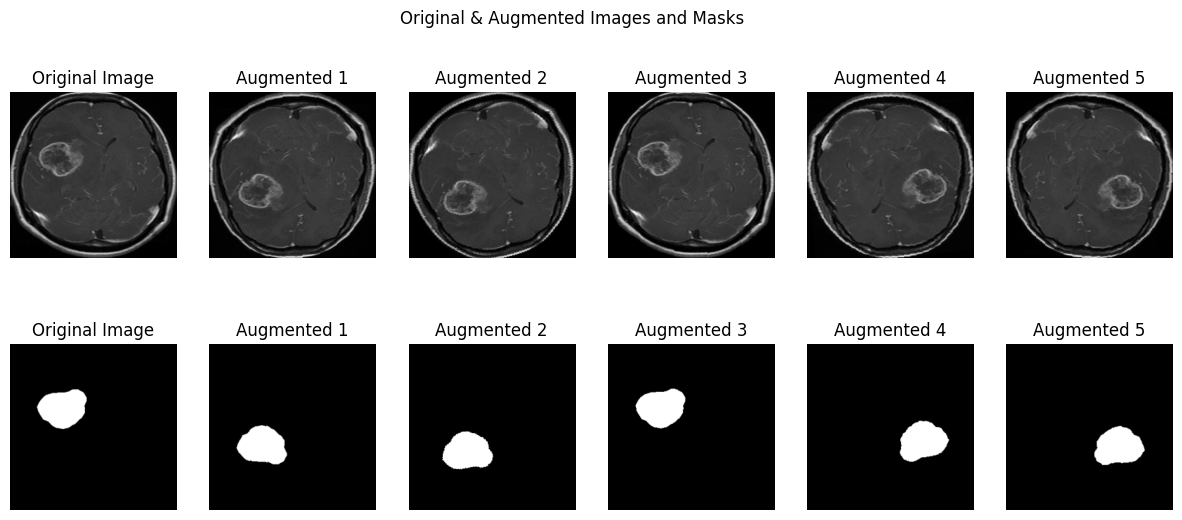

In [13]:
train_dataset.show_sample(0)

In [14]:
print("Number of images train_dataset = ", len(train_dataset))
print("Number of images in each train_dataset = ", len(train_dataset[0]))
print("Total = ",(len(train_dataset)*len(train_dataset[0])))

Number of images train_dataset =  12864
Number of images in each train_dataset =  2
Total =  25728


In [15]:
print("Number of images val_dataset = ", len(val_dataset))
print("Number of images in each val_dataset = ", len(val_dataset[0]))
print("Total = ",(len(val_dataset)*len(val_dataset[0])))

Number of images val_dataset =  460
Number of images in each val_dataset =  2
Total =  920


In [16]:
print("Number of images test_dataset = ", len(test_dataset))
print("Number of images in each test_dataset = ", len(test_dataset[0]))
print("Total = ",(len(test_dataset)*len(test_dataset[0])))

Number of images test_dataset =  460
Number of images in each test_dataset =  2
Total =  920


# Model

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi
        
class AttentionUNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(AttentionUNET, self).__init__()
        self.out_channels = out_channels
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.attentions.append(AttentionBlock(F_g=feature, F_l=feature, F_int=feature // 2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] #reverse list

        for idx in range(0, len(self.ups), 2):  #do up and double_conv
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = self.attentions[idx // 2](skip_connection, x)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3,1, 512, 512)).to(DEVICE)
    model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)
    preds = model(x)
    print(f"Test shape = {x.shape}")
    print(f"Prediction shape = {preds.shape}")
    summary(model, (1, 512, 512))

if __name__ == "__main__":
    test()

Test shape = torch.Size([3, 1, 512, 512])
Prediction shape = torch.Size([3, 1, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             288
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,216
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
        DoubleConv-7         [-1, 32, 512, 512]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          18,432
      BatchNorm2d-10         [-1, 64, 256, 256]             128
             ReLU-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
      BatchNo

# Training

In [30]:
# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 20
LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# function to save model checkpoint
def save_checkpoint(state, filename="my_attention_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

# function to load model checkpoint
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

# function to calculate IoU
def calculate_iou(preds, targets):
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-8)  # Adding epsilon to avoid division by zero

# function to check accuracy, return Dice score, IoU score & validation loss
def check_accuracy(loader, model, loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0  # IoU tracking
    total_loss = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)  # Raw logits (no sigmoid yet)
            loss = loss_fn(logits, y)  # Compute loss before thresholding
            total_loss += loss.item()

            preds = torch.sigmoid(logits)  # Convert logits to probabilities
            preds_bin = (preds > 0.5).float()  # Thresholding after loss

            num_correct += (preds_bin == y).sum().item()
            num_pixels += torch.numel(preds_bin)
            dice_score += (2 * (preds_bin * y).sum()) / ((preds_bin + y).sum() + 1e-8)
            iou_score += calculate_iou(preds_bin, y)  # Compute IoU

    avg_loss = total_loss / len(loader)  # Compute average validation loss
    avg_dice = dice_score / len(loader)  # Compute average Dice score
    avg_iou = iou_score / len(loader)  # Compute average IoU score

    print(f"Accuracy: {num_correct}/{num_pixels} ({num_correct / num_pixels * 100:.2f}%)")
    print(f"Dice Score: {avg_dice:.4f}")
    print(f"IoU Score: {avg_iou:.4f}")  # Print IoU score

    model.train()
    return avg_dice, avg_iou, avg_loss

# function to save predictions as images (Restored Original Version)
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y, f"{folder}/gt_{idx}.png")
    model.train()

# function to train model
def train_fn(loader, model, optimizer, loss_fn, scaler, val_loader):
    loop = tqdm(loader, desc="Training", leave=True)
    total_loss = 0
    val_loss = 0  # To store validation loss
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()  # Add loss for this batch

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Compute validation loss on one batch for quick monitoring
        with torch.no_grad():
            val_data, val_targets = next(iter(val_loader))  # Get a validation batch
            val_data, val_targets = val_data.to(DEVICE), val_targets.to(DEVICE)
        
            val_logits = model(val_data)  # Get raw outputs
            val_loss = loss_fn(val_logits, val_targets).item()  # Compute loss directly on logits
        
            # Convert logits to probabilities AFTER loss calculation
            val_preds = torch.sigmoid(val_logits)
            val_preds = (val_preds > 0.5).float()

        # Update tqdm loop to display training and validation loss
        loop.set_postfix(train_loss=loss.item(), val_loss=val_loss)
    
    return total_loss / len(loader)  # return average training loss


def main():
    print(f"Device used : {DEVICE}")
    model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_attention_checkpoint.pth.tar"), model)

    check_accuracy(val_loader, model,loss_fn, device=DEVICE)
    scaler = torch.amp.GradScaler('cuda')

    best_dice_score = 0  # Track the best Dice score
    best_iou_score = 0 # Track the best IoU score
    best_checkpoint = None  # Store the best checkpoint
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    iou_scores = []  # List to store IoU scores

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler,val_loader)
        train_losses.append(train_loss)  # store training loss
        
        # validate and get Dice score, IoU, and val loss
        dice_score, iou_score, val_loss = check_accuracy(val_loader, model, loss_fn, device=DEVICE)
        val_losses.append(val_loss)  # store validation loss
        iou_scores.append(iou_score)  # store IoU score

        # Save model if Dice score improves
        if (dice_score+iou_score)/2 > (best_dice_score+best_iou_score)/2:
            best_dice_score = dice_score
            best_iou_score = iou_score
            best_checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(best_checkpoint)  # Save the best checkpoint

        # if Dice score stops improving, break training
        elif (dice_score+iou_score)/2 == (best_dice_score+best_iou_score)/2:
            print("Stopping early as average Dice+IoU score did not improve.")
            break

        # to save some sample predictions
        save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

    print("Training Complete. \nBest Dice Score:", best_dice_score)
    print("Best IoU Score:", best_iou_score)

    # to save final best checkpoint after training ends
    if best_checkpoint:
        save_checkpoint(best_checkpoint, filename="best_attention_model.pth.tar")

    # to save losses and IoU scores for later use
    np.save("train_losses.npy", np.array(train_losses))
    np.save("val_losses.npy", np.array(val_losses))
    np.save("iou_scores.npy", np.array([score.cpu().item() for score in iou_scores]))# Save IoU scores

if __name__ == "__main__":
    main()

Device used : cuda
Accuracy: 29232789/30146560 (96.97%)
Dice Score: 0.0000
IoU Score: 0.0000

Epoch 1/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29580606/30146560 (98.12%)
Dice Score: 0.6322
IoU Score: 0.4719
=> Saving checkpoint

Epoch 2/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29678691/30146560 (98.45%)
Dice Score: 0.7548
IoU Score: 0.6107
=> Saving checkpoint

Epoch 3/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29735315/30146560 (98.64%)
Dice Score: 0.7734
IoU Score: 0.6366
=> Saving checkpoint

Epoch 4/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29751748/30146560 (98.69%)
Dice Score: 0.7810
IoU Score: 0.6471
=> Saving checkpoint

Epoch 5/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29777255/30146560 (98.77%)
Dice Score: 0.8021
IoU Score: 0.6742
=> Saving checkpoint

Epoch 6/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29785364/30146560 (98.80%)
Dice Score: 0.8166
IoU Score: 0.6932
=> Saving checkpoint

Epoch 7/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29772727/30146560 (98.76%)
Dice Score: 0.8111
IoU Score: 0.6859

Epoch 8/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29771415/30146560 (98.76%)
Dice Score: 0.8085
IoU Score: 0.6824

Epoch 9/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29805450/30146560 (98.87%)
Dice Score: 0.8283
IoU Score: 0.7109
=> Saving checkpoint

Epoch 10/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29788089/30146560 (98.81%)
Dice Score: 0.8109
IoU Score: 0.6845

Epoch 11/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29800722/30146560 (98.85%)
Dice Score: 0.8233
IoU Score: 0.7041

Epoch 12/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29798476/30146560 (98.85%)
Dice Score: 0.8248
IoU Score: 0.7057

Epoch 13/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29799177/30146560 (98.85%)
Dice Score: 0.8238
IoU Score: 0.7045

Epoch 14/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29794647/30146560 (98.83%)
Dice Score: 0.8250
IoU Score: 0.7058

Epoch 15/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29814130/30146560 (98.90%)
Dice Score: 0.8328
IoU Score: 0.7159
=> Saving checkpoint

Epoch 16/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29812823/30146560 (98.89%)
Dice Score: 0.8332
IoU Score: 0.7177
=> Saving checkpoint

Epoch 17/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29810188/30146560 (98.88%)
Dice Score: 0.8306
IoU Score: 0.7133

Epoch 18/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29815457/30146560 (98.90%)
Dice Score: 0.8420
IoU Score: 0.7297
=> Saving checkpoint

Epoch 19/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29800722/30146560 (98.85%)
Dice Score: 0.8252
IoU Score: 0.7062

Epoch 20/20


Training:   0%|          | 0/804 [00:00<?, ?it/s]

Accuracy: 29808780/30146560 (98.88%)
Dice Score: 0.8332
IoU Score: 0.7171
Training Complete. 
Best Dice Score: tensor(0.8420, device='cuda:0')
Best IoU Score: tensor(0.7297, device='cuda:0')
=> Saving checkpoint


### Graphs

In [132]:
train_losses = np.load("train_losses.npy")
val_losses = np.load("val_losses.npy")
iou_scores = np.load("iou_scores.npy")

print(f"Train Losses : {np.array(train_losses)}")
print(f"Validation Losses : {np.array(val_losses)}")
print(f"Train Losses : {np.array(iou_scores)}")

Train Losses : [0.29439181 0.13851315 0.07882122 0.05222124 0.03914297 0.03161604
 0.02660512 0.02347179 0.0192256  0.01943492 0.01847355 0.01739236
 0.01762157 0.01576635 0.01539082 0.01485899 0.01454    0.01458085
 0.0136678  0.0137299 ]
Validation Losses : [0.18871058 0.10077019 0.06206867 0.04718326 0.03634143 0.03136616
 0.03073411 0.03150512 0.02650444 0.02937338 0.02746068 0.02750215
 0.02791927 0.02665629 0.02655249 0.0265265  0.0280345  0.02601606
 0.02862861 0.02853104]
Train Losses : [0.47190723 0.61067069 0.63660771 0.64713681 0.67420888 0.69319999
 0.68591678 0.68243021 0.710895   0.6844539  0.70405847 0.7056849
 0.70450044 0.70575321 0.7158969  0.71770269 0.71329182 0.7296949
 0.70624506 0.71707368]


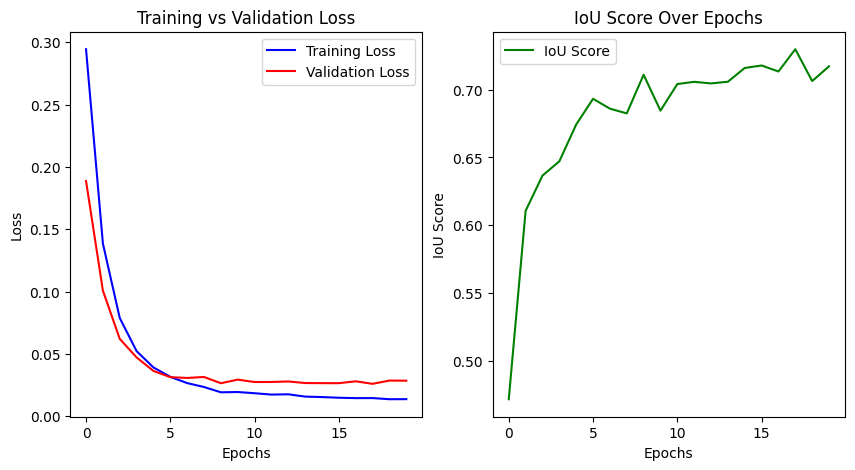

In [34]:
train_losses = np.load("train_losses.npy")
val_losses = np.load("val_losses.npy")
iou_scores = np.load("iou_scores.npy")

plt.figure(figsize=(10,5))

# training & validation loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

# IoU scores
plt.subplot(1,2,2)
plt.plot(iou_scores, label="IoU Score", color='green')
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.legend()
plt.title("IoU Score Over Epochs")

plt.show()


# Training prediction batch-wise visualization

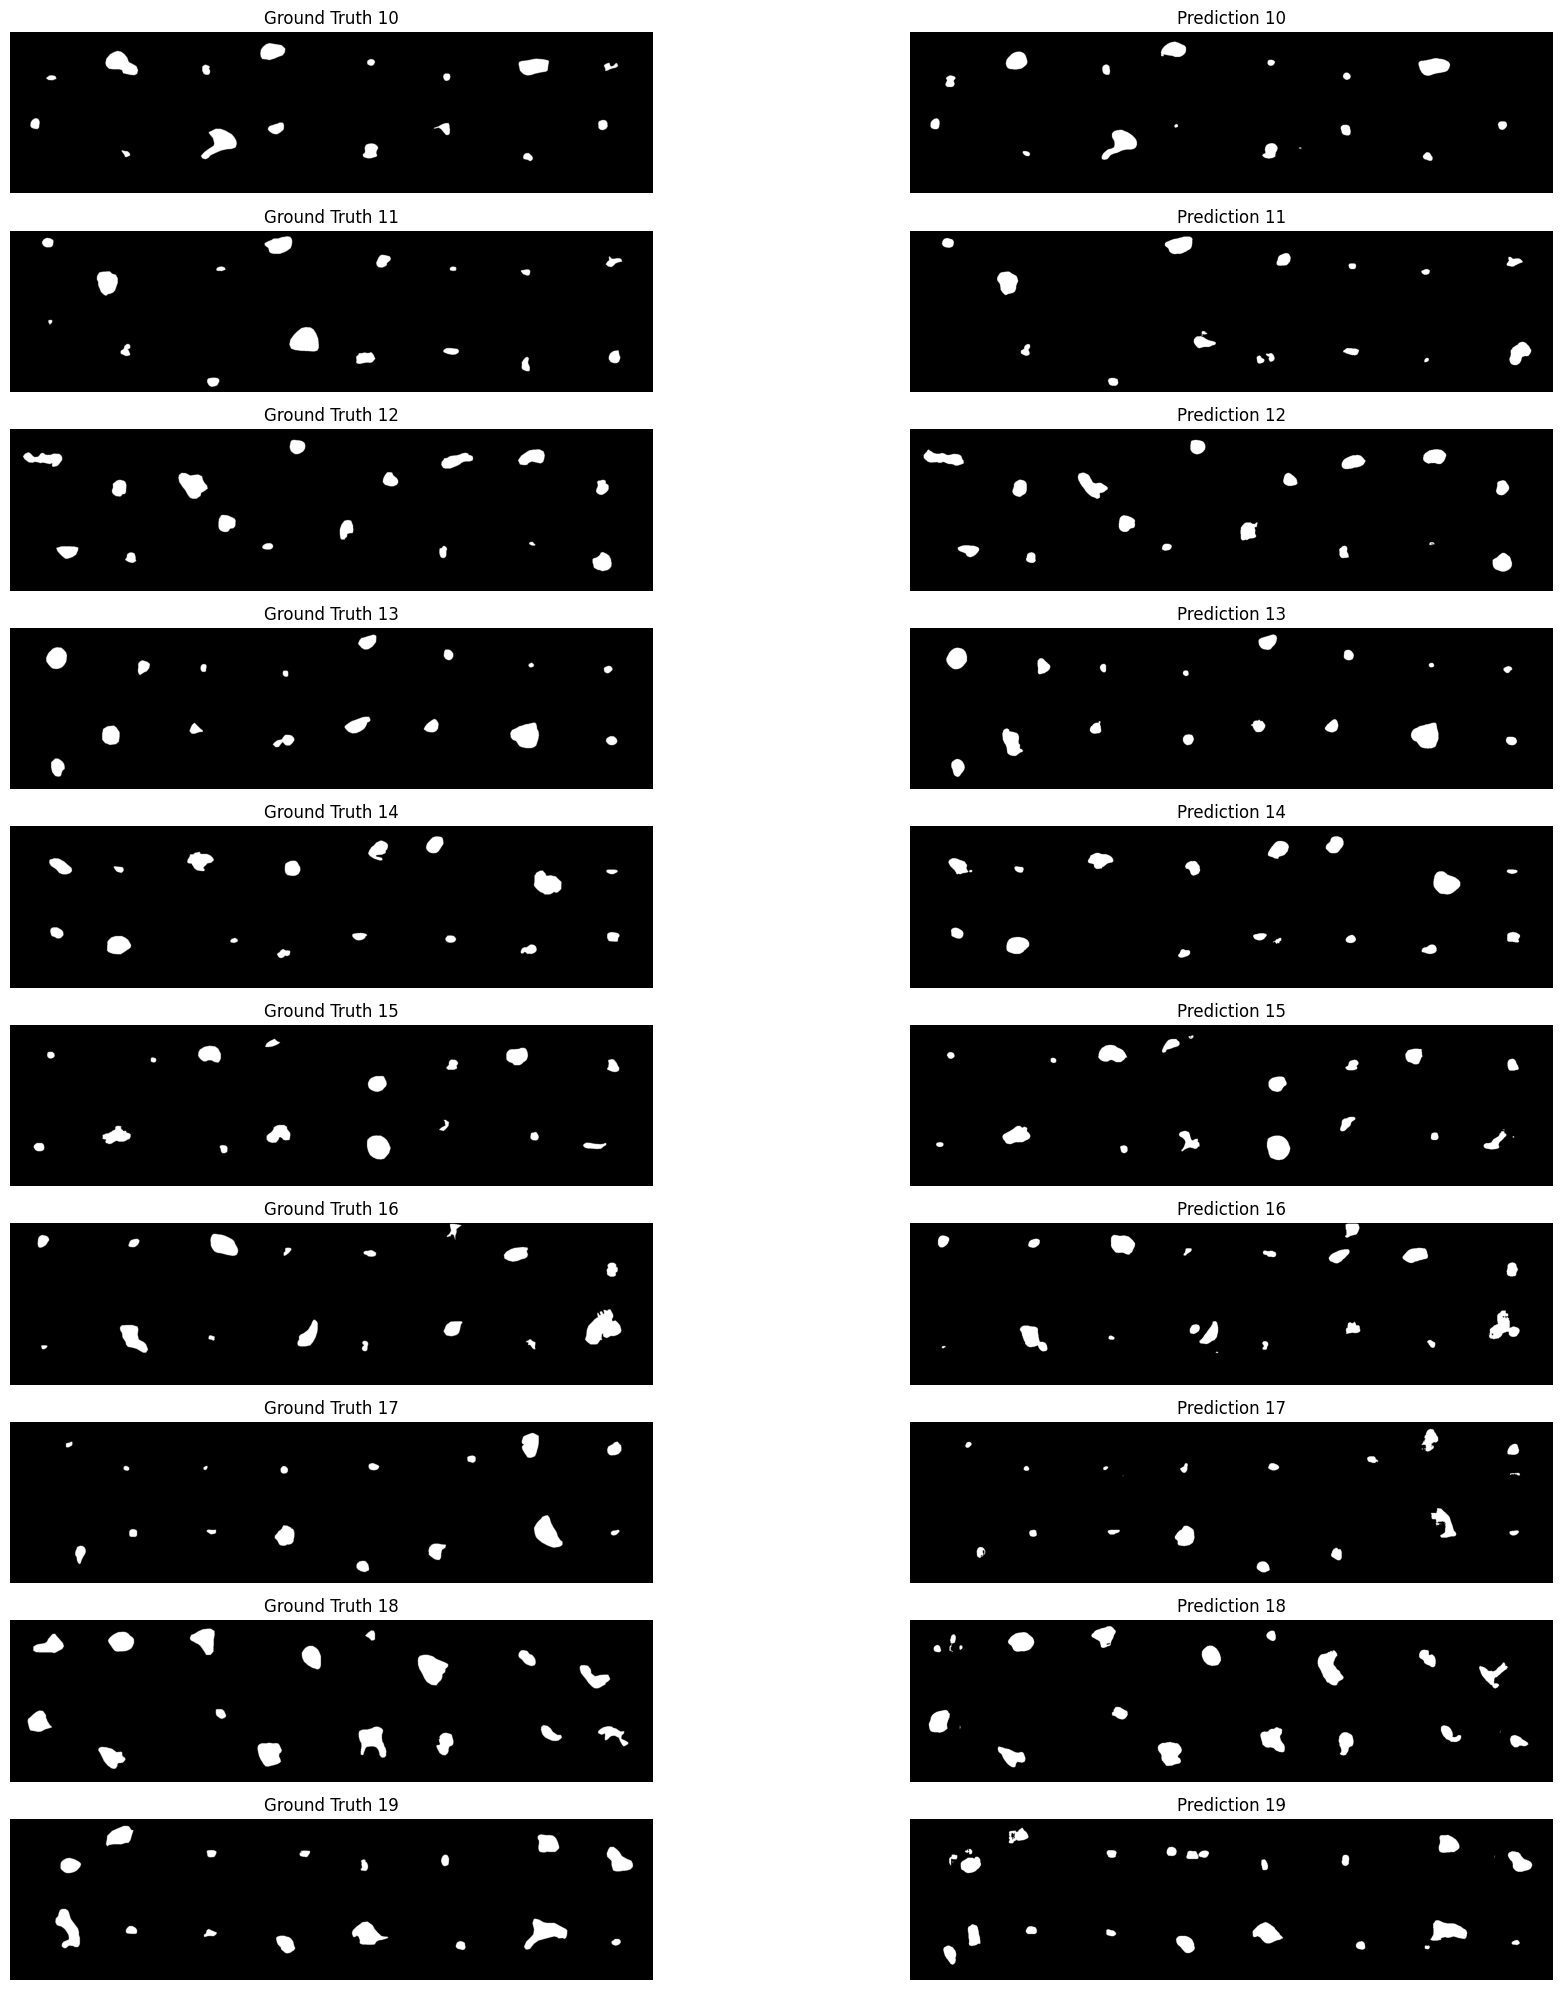

In [37]:
saved_images_path = "saved_images/"

saved_images = sorted(os.listdir(saved_images_path))

fig, axes = plt.subplots(10, 2, figsize=(20, 20))

for i in range(10):
    pred_path = os.path.join(saved_images_path, f"pred_{i+10}.png")
    pred_mask_path = os.path.join(saved_images_path, f"gt_{i+10}.png")  # Ground truth mask

    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

    if pred_img is None:
        print(f"Warning: {pred_path} not found!")
        continue
    if mask_img is None:
        print(f"Warning: {pred_mask_path} not found!")
        continue

    axes[i, 0].imshow(mask_img, cmap="gray")
    axes[i, 0].set_title(f"Ground Truth {i+10}")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(pred_img, cmap="gray")
    axes[i, 1].set_title(f"Prediction {i+10}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Predict any image from test dataset

In [79]:
# Load trained model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize UNET model (Ensure UNET class is defined/imported before this)
model = AttentionUNET(in_channels=1, out_channels=1).to(DEVICE)

# Load the checkpoint from Kaggle dataset
checkpoint_path = "/kaggle/input/attentionunet-dummy/pytorch/default/1/best_attention_model.pth.tar" #when using downloaded
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=True)

# Load model state
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Define Preprocessing Transform
val_test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

def predict_single_image(img_path, mask_path, model):
    """
    Given an image path, this function returns the original image, 
    predicted mask, and ground truth mask.
    """
    # load original image & mask
    image = Image.open(img_path).convert("L")  # Convert to grayscale
    mask = Image.open(mask_path).convert("L")  # Convert to grayscale
    
    # transform image
    input_tensor = val_test_transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # model prediction
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(input_tensor))
        pred_mask = (pred_mask > 0.5).float()

    # convert Tensors to Numpy
    original_np = np.array(image.resize((256,256)))
    pred_mask_np = pred_mask.cpu().squeeze().numpy()
    inv_pred_mask_np = (pred_mask_np > 0.5)
    inv_pred_mask_np = np.where(pred_mask_np == 1, 0, 255)
    mask_np = val_test_transform(mask).cpu().squeeze().numpy()

    # create Cropped Tumor Image (White background, only tumor visible)
    tumor_only = np.where(pred_mask_np == 1,original_np,255)

    # IoU (Intersection over Union) Calculation
    intersection = np.logical_and(pred_mask_np, mask_np).sum()
    union = np.logical_or(pred_mask_np, mask_np).sum()
    iou_score = intersection / (union + 1e-7)  # Add small value to avoid division by zero

    # Dice Score Calculation
    dice_score = (2 * intersection) / (pred_mask_np.sum() + mask_np.sum() + 1e-7)  # Avoid division by zero

    print(f"IoU Score: {iou_score:.4f}")
    print(f"Dice Score: {dice_score:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    titles = ["Original Image", "Ground Truth Mask", "Predicted Mask","Tumor Cropped"]
    images = [original_np, mask_np, inv_pred_mask_np, tumor_only]

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.set_title(titles[i])
        ax.axis("off")

    plt.show()

Testing on random image: 556.png
Image path :  /kaggle/working/cropped_images/images/556.png
Mask path :  /kaggle/working/cropped_images/masks/556.png
IoU Score: 0.7645
Dice Score: 0.9047


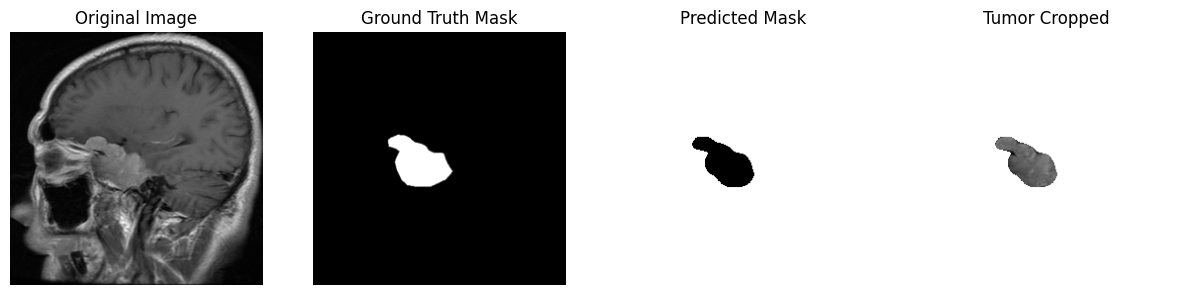

In [80]:
# -----------------------
# Test on a sample image
# -----------------------

# choose a random test image and mask
rand_idx = random.randint(0, len(test_imgs) - 1)
img_name = test_imgs[rand_idx]
mask_name = test_masks[rand_idx]

img_path_test = os.path.join(image_path, img_name)
mask_path_test = os.path.join(mask_path, mask_name)

print(f"Testing on random image: {img_name}")
print("Image path : ", img_path_test)
print("Mask path : ", mask_path_test)

predict_single_image(img_path_test, mask_path_test, model)